## Traininig the High Level Feature classifier with TensorFlow/Keras using data in TFRecord format

**4.0 Tensorflow/Keras and Petastorm, HLF classifier** This notebooks trains a dense neural network for the particle classifier using High Level Features. It uses TensorFlow/Keras on a single node. Spark is not used in this case, data is read from TFRecord format.

To run this notebook we used the following configuration:
* *Software stack*: TensorFlow 1.14.0 or 2.0.0_beta1
* *Platform*: CentOS 7, Python 3.6

## Create the Keras model

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

In [2]:
tf.version.VERSION

'2.0.0-beta0'

In [3]:
# only needed for TensorFlow 1.x
# tf.enable_eager_execution()

### Create model

In [4]:
def create_model(nh_1, nh_2, nh_3):
    ## Create model
    model = Sequential()
    model.add(Dense(nh_1, input_shape=(14,), activation='relu'))
    model.add(Dense(nh_2, activation='relu'))
    model.add(Dense(nh_3, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    ## Compile model
    optimizer = 'Adam'
    loss = 'categorical_crossentropy'
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    
    return model

keras_model = create_model(50,20,10)

In [5]:
keras_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                750       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 33        
Total params: 2,013
Trainable params: 2,013
Non-trainable params: 0
_________________________________________________________________


## Load data and train the Keras model

In [6]:
import os
CWD=os.getcwd()

# test dataset in 2 pieces
PATH = CWD +  "/../Data/testUndersampled_HLF_features.tfrecord/"
file_test_dataset = [PATH + "part-r-00000", PATH + "part-r-00001"]

# training dataset in 4 pieces
PATH = CWD +  "/../Data/trainUndersampled_HLF_features.tfrecord/"
file_train_dataset = [PATH + "part-r-00000", PATH + "part-r-00001", PATH + "part-r-00002", PATH + "part-r-00003"]

In [7]:
test_dataset=tf.data.TFRecordDataset(file_test_dataset)
train_dataset=tf.data.TFRecordDataset(file_train_dataset)

In [8]:
# use for debug
# for record in test_dataset.take(1):
#     print(record)

In [9]:
# Function to decode TF records into the required features and labels
def decode(serialized_example):
    deser_features = tf.io.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
          'encoded_label': tf.io.FixedLenFeature((3), tf.float32),
          'HLF_input': tf.io.FixedLenFeature((14), tf.float32),
          })
    return(deser_features['HLF_input'], deser_features['encoded_label'])

In [10]:
parsed_test_dataset=test_dataset.map(decode, num_parallel_calls=tf.data.experimental.AUTOTUNE)
parsed_train_dataset=train_dataset.map(decode, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [11]:
# Show and example of the parsed data
for record in parsed_test_dataset.take(1):
    print(record)

(<tf.Tensor: id=240, shape=(14,), dtype=float32, numpy=
array([1.51507333e-02, 3.51102836e-03, 8.74629617e-01, 1.06784595e-04,
       1.33333340e-01, 0.00000000e+00, 7.00169418e-04, 2.50178307e-01,
       2.44209673e-02, 5.44097781e-01, 1.05042383e-01, 0.00000000e+00,
       0.00000000e+00, 1.00000000e+00], dtype=float32)>, <tf.Tensor: id=241, shape=(3,), dtype=float32, numpy=array([1., 0., 0.], dtype=float32)>)


In [12]:
train=parsed_train_dataset.shuffle(10000)
train=train.cache()
train=train.batch(128)
train=train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
train=train.repeat()

In [13]:
train

<RepeatDataset shapes: ((None, 14), (None, 3)), types: (tf.float32, tf.float32)>

In [14]:
steps_per_epoch=3426083//128  # there are 3426083 samples in the training dataset
steps_per_epoch

26766

In [15]:
validation_steps=856090//128  # there are 856090 samples in the test dataset
validation_steps

6688

In [16]:
test=parsed_test_dataset.batch(128)
test=test.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test=test.repeat()

In [17]:
# train the Keras model
%time history = keras_model.fit(train, steps_per_epoch=steps_per_epoch, \
                          validation_data=test, validation_steps=validation_steps, \
                          epochs=5, verbose=1)


Epoch 1/5


26766/26766 [==============================] - 61s 2ms/step - loss: 0.2829 - accuracy: 0.8960 - val_loss: 0.2498 - val_accuracy: 0.9080
Epoch 2/5
26766/26766 [==============================] - 43s 2ms/step - loss: 0.2448 - accuracy: 0.9095 - val_loss: 0.2372 - val_accuracy: 0.9126
Epoch 3/5
26766/26766 [==============================] - 43s 2ms/step - loss: 0.2378 - accuracy: 0.9121 - val_loss: 0.2333 - val_accuracy: 0.9139
Epoch 4/5
26766/26766 [==============================] - 43s 2ms/step - loss: 0.2342 - accuracy: 0.9133 - val_loss: 0.2305 - val_accuracy: 0.9148
Epoch 5/5
26766/26766 [==============================] - 43s 2ms/step - loss: 0.2315 - accuracy: 0.9143 - val_loss: 0.2282 - val_accuracy: 0.9159
CPU times: user 11min 40s, sys: 1min 50s, total: 13min 31s
Wall time: 3min 54s


## Performance metrics

<IPython.core.display.Javascript object>


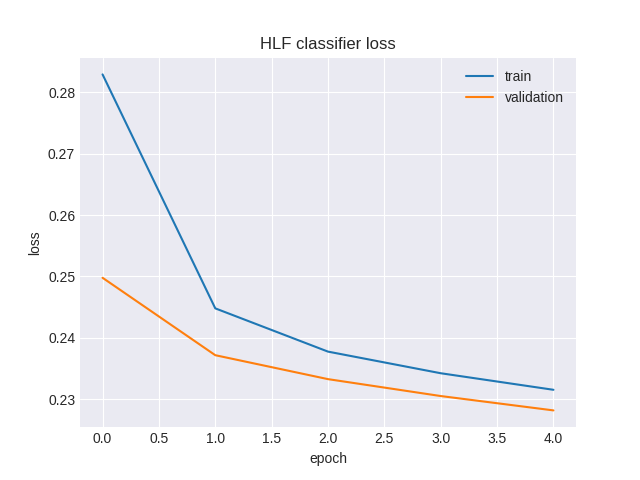

In [18]:
%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
# Graph with loss vs. epoch

plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.title("HLF classifier loss")
plt.show()

<IPython.core.display.Javascript object>


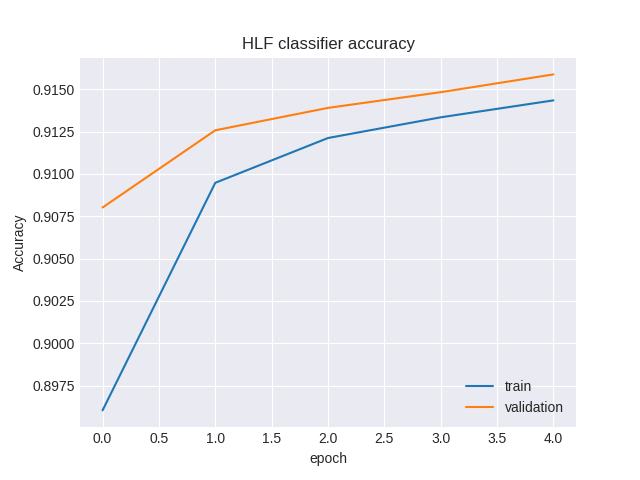

In [20]:
# Graph with accuracy vs. epoch
%matplotlib notebook
plt.figure()
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.title("HLF classifier accuracy")
plt.show()

## Confusion Matrix

In [21]:
y_pred = history.model.predict(test, steps=validation_steps)
num_entries=y_pred[:,0].size

In [36]:
y_test_all = [labels.numpy() for features,labels in parsed_test_dataset.__iter__()]

In [37]:
y_true = np.stack(y_test_all[:num_entries])

In [38]:
from sklearn.metrics import accuracy_score

print('Accuracy of the HLF classifier: {:.4f}'.format(
    accuracy_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the HLF classifier: 0.9159


<IPython.core.display.Javascript object>


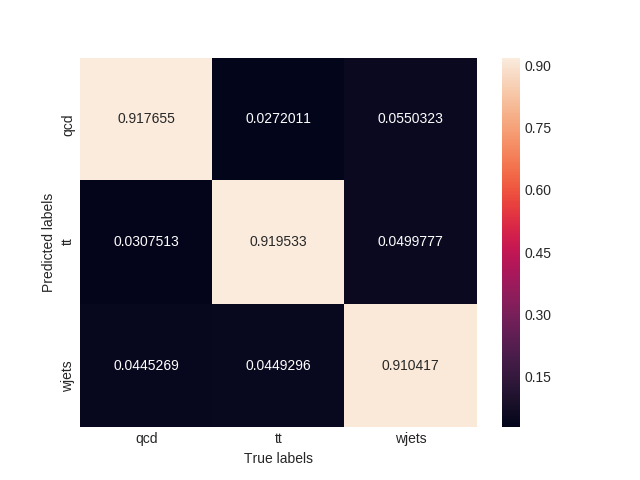

In [39]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

## Normalize CM
cm = cm / cm.astype(np.float).sum(axis=1)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## ROC and AUC

In [40]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [41]:
# Dictionary containign ROC-AUC for the three classes 
roc_auc

{0: 0.9872533108300671, 1: 0.9853792057824486, 2: 0.9813268620468237}

<IPython.core.display.Javascript object>


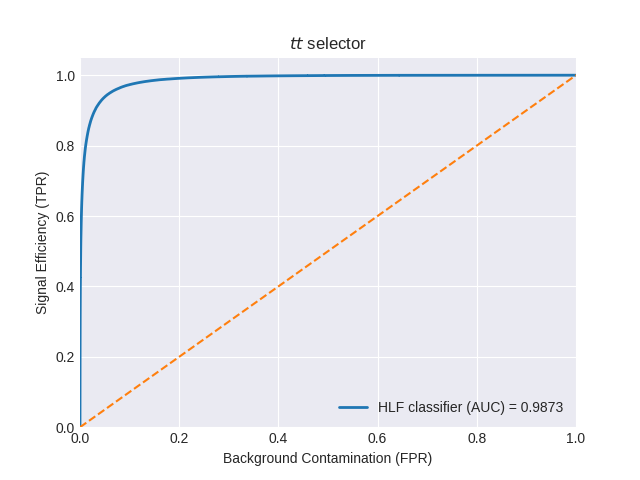

In [42]:
%matplotlib notebook

# Plot roc curve 
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')


plt.figure()
plt.plot(fpr[0], tpr[0], lw=2, 
         label='HLF classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.show()